
# TP CAM
### Diane LINGRAND 

diane.lingrand@univ-cotedazur.fr   
Décembre 2021

## Introduction

In [1]:
from IPython.display import Image
import tensorflow 
import tensorflow as tf
print(tensorflow.__version__)
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation
import matplotlib.pyplot as plt


2.9.2


**The GPU**



To enable GPU backend in Google colab for your notebook:

1.   Runtime (top left corner) -> Change runtime type
2.   Put GPU as "Hardware accelerator"
3.   Save.

Or run the next cell:

In [2]:
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


### Loading the dataset
In this part, we will use photographies of animals from the kaggle dataset [animals-10](https://www.kaggle.com/alessiocorrado99/animals10). Please connect to their site before loading the dataset from this [zip file](http://www.i3s.unice.fr/~lingrand/raw-img.zip). Decompress the zip file on your disk.

If you are using google colab, there is no need to download the dataset because I have a copy on my drive. You just need add to your drive this shared folder: https://drive.google.com/drive/folders/15cB1Ky-7OTUqfcQDZZyzc5HArt0GA6Sm?usp=sharing
You need to click on the link and click on "Add shortcut to Drive" and then select "My Drive".

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import glob
# when processing time is long, it's nice to see the progress bar
#!pip install tqdm
from tqdm import tqdm

### loading train data

Please read the code before running any of the cells!

In [5]:
# datasetRoot='/home/lingrand/Ens/MachineLearning/animals/raw-img/'
#datasetRoot='/whereYouPutTheImages/'
datasetRoot='/content/drive/My Drive/raw-img/'
# I suggest to reduce the number of classes for a first trial. 
# If you finish this notebook before the end of the course, you can add more classes (and images per class).
classes = ['mucca', 'elefante', 'gatto'] #, 'cavallo', 'scoiattolo', 'ragno', 'pecora', 'farfalla', 'gallina', 'cane']
nbClasses = len(classes)

#training data

rootTrain = datasetRoot+'train/'
classLabel = 0
reducedSizePerClass = 200 #in order to reduce the number of images per class
totalImg = nbClasses * reducedSizePerClass
xTrain = np.empty(shape=(totalImg,224,224,3))
yTrain = []
first = True
i= 0
for cl in classes:
    listImages = glob.glob(rootTrain+cl+'/*')
    yTrain += [classLabel]*reducedSizePerClass #len(listImages) # note that here ...
    for pathImg in tqdm(listImages[:reducedSizePerClass]): # and here, we have reduced the data to be loaded (only 1000 per class)
        img = image.load_img(pathImg, target_size=(224,224))
        im = image.img_to_array(img)
        im = np.expand_dims(im, axis=0)
        im = preprocess_input(im)
        xTrain[i,:,:,:] = im
        i += 1
    classLabel += 1
print(len(yTrain))
print(xTrain.shape)
yTrain = tensorflow.keras.utils.to_categorical(yTrain, nbClasses)


100%|██████████| 200/200 [00:02<00:00, 67.53it/s] 

600
(600, 224, 224, 3)


In order to speed-up the time spent on this part of the lab, you may have noticed that we reduced the number of classes and the number of images per class. You can change these few lines of code if you want to work on the whole dataset.

### loading test data

In [6]:
#you need to use the same classes for the test dataset than for the train dataset
rootTest = datasetRoot+'test/'
classLabel = 0

totalTestImg = 0
for cl in classes:
    totalTestImg += len(glob.glob(rootTest+cl+'/*'))

print("There are ",totalTestImg, " images in test dataset.")
xTest = np.empty(shape=(totalTestImg,224,224,3))
yTest = []
i = 0

for cl in classes:
    listImages = glob.glob(rootTest+cl+'/*')
    yTest += [classLabel]*len(listImages)
    for pathImg in listImages:
        img = image.load_img(pathImg, target_size=(224, 224))
        im = image.img_to_array(img)
        im = np.expand_dims(im, axis=0)
        im = preprocess_input(im)
        if(np.max(im)==0):
            print('n')
        xTest[i,:,:,:] = im.copy()
        if(np.max(xTest[i])==0):
            print('m')
        i+=1
    classLabel += 1
print(len(yTest))
print(xTest.shape)
print(yTest)
yTest = tensorflow.keras.utils.to_categorical(yTest, nbClasses)

There are  991  images in test dataset.
991
(991, 224, 224, 3)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

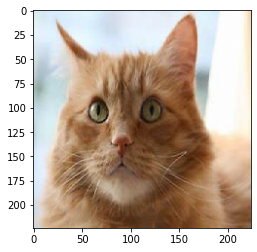

In [7]:
i=135
img = image.load_img(listImages[i], target_size=(224, 224))
plt.imshow(img)
plt.show()

## CAM Class Activation Map

In [12]:
VGGmodel = VGG16(weights='imagenet', include_top=False)
# we will add layers to this feature extraction part of VGG network
m = VGGmodel.output
# we start with a global average pooling
m = GlobalAveragePooling2D()(m)
# finally, the softmax layer for predictions (we have nbClasses classes)
predictions = Dense(nbClasses, activation='softmax')(m)

# global network
model = Model(inputs=VGGmodel.input, outputs=predictions)


In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [14]:
ourCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

In [15]:
# training part I: training only the classification part (the end)
for layer in VGGmodel.layers:
    layer.trainable = False
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(xTrain, yTrain, epochs=2000, batch_size=128, validation_split=0.2, callbacks=[ourCallback],verbose=1)

Epoch 1/2000
4/4 [==============================] - 7s 2s/step - loss: 8.2920 - accuracy: 0.1937 - val_loss: 12.6098 - val_accuracy: 0.0500
Epoch 2/2000
4/4 [==============================] - 5s 1s/step - loss: 3.8056 - accuracy: 0.4417 - val_loss: 7.7681 - val_accuracy: 0.1583
Epoch 3/2000
4/4 [==============================] - 5s 1s/step - loss: 2.3258 - accuracy: 0.5813 - val_loss: 4.3276 - val_accuracy: 0.3833
Epoch 4/2000
4/4 [==============================] - 3s 869ms/step - loss: 1.5467 - accuracy: 0.7000 - val_loss: 3.2445 - val_accuracy: 0.4750
Epoch 5/2000
4/4 [==============================] - 4s 970ms/step - loss: 1.0983 - accuracy: 0.7542 - val_loss: 2.3659 - val_accuracy: 0.5833
Epoch 6/2000
4/4 [==============================] - 4s 948ms/step - loss: 0.8166 - accuracy: 0.8083 - val_loss: 1.9174 - val_accuracy: 0.6667
Epoch 7/2000
4/4 [==============================] - 4s 976ms/step - loss: 0.6145 - accuracy: 0.8542 - val_loss: 1.4204 - val_accuracy: 0.7417
Epoch 8/2000
4

In [20]:
layer = model.get_layer('dense_1')
w = layer.get_weights()
print("number of weights: ", len(w))
w2 = w[0]
print(w2.shape)


number of weights:  2
(512, 3)


In [21]:
allFeatures = VGGmodel.predict(xTest)

31/31 [==============================] - 13s 318ms/step


In [22]:
predClasses = model.predict(xTest)

31/31 [==============================] - 7s 218ms/step


In [23]:
xTest.shape

(991, 224, 224, 3)

In [24]:
index = 800
maps = allFeatures[index]
print("dim of maps = ", maps.shape)

dim of maps =  (7, 7, 512)


In [25]:
#predicted class
cl = np.argmax(predClasses[index])
print("class = ", cl)

class =  2


In [26]:
we = w2[:,cl]

In [27]:
cam = maps[:,:,0]*we[0]
for i in range(1,512):
    subim = maps[:,:,i]
    cam += subim*we[i]


In [28]:
# more compact
cam = np.inner(maps,we)


(224, 224, 3)


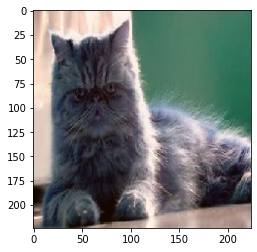

In [29]:
i=index
print(xTest[i].shape)
if np.max(xTest[i]) > np.min(xTest[i]):
    image = (xTest[i]-np.min(xTest[i]))/(np.max(xTest[i])-np.min(xTest[i]))
    plt.imshow(image)
plt.show()

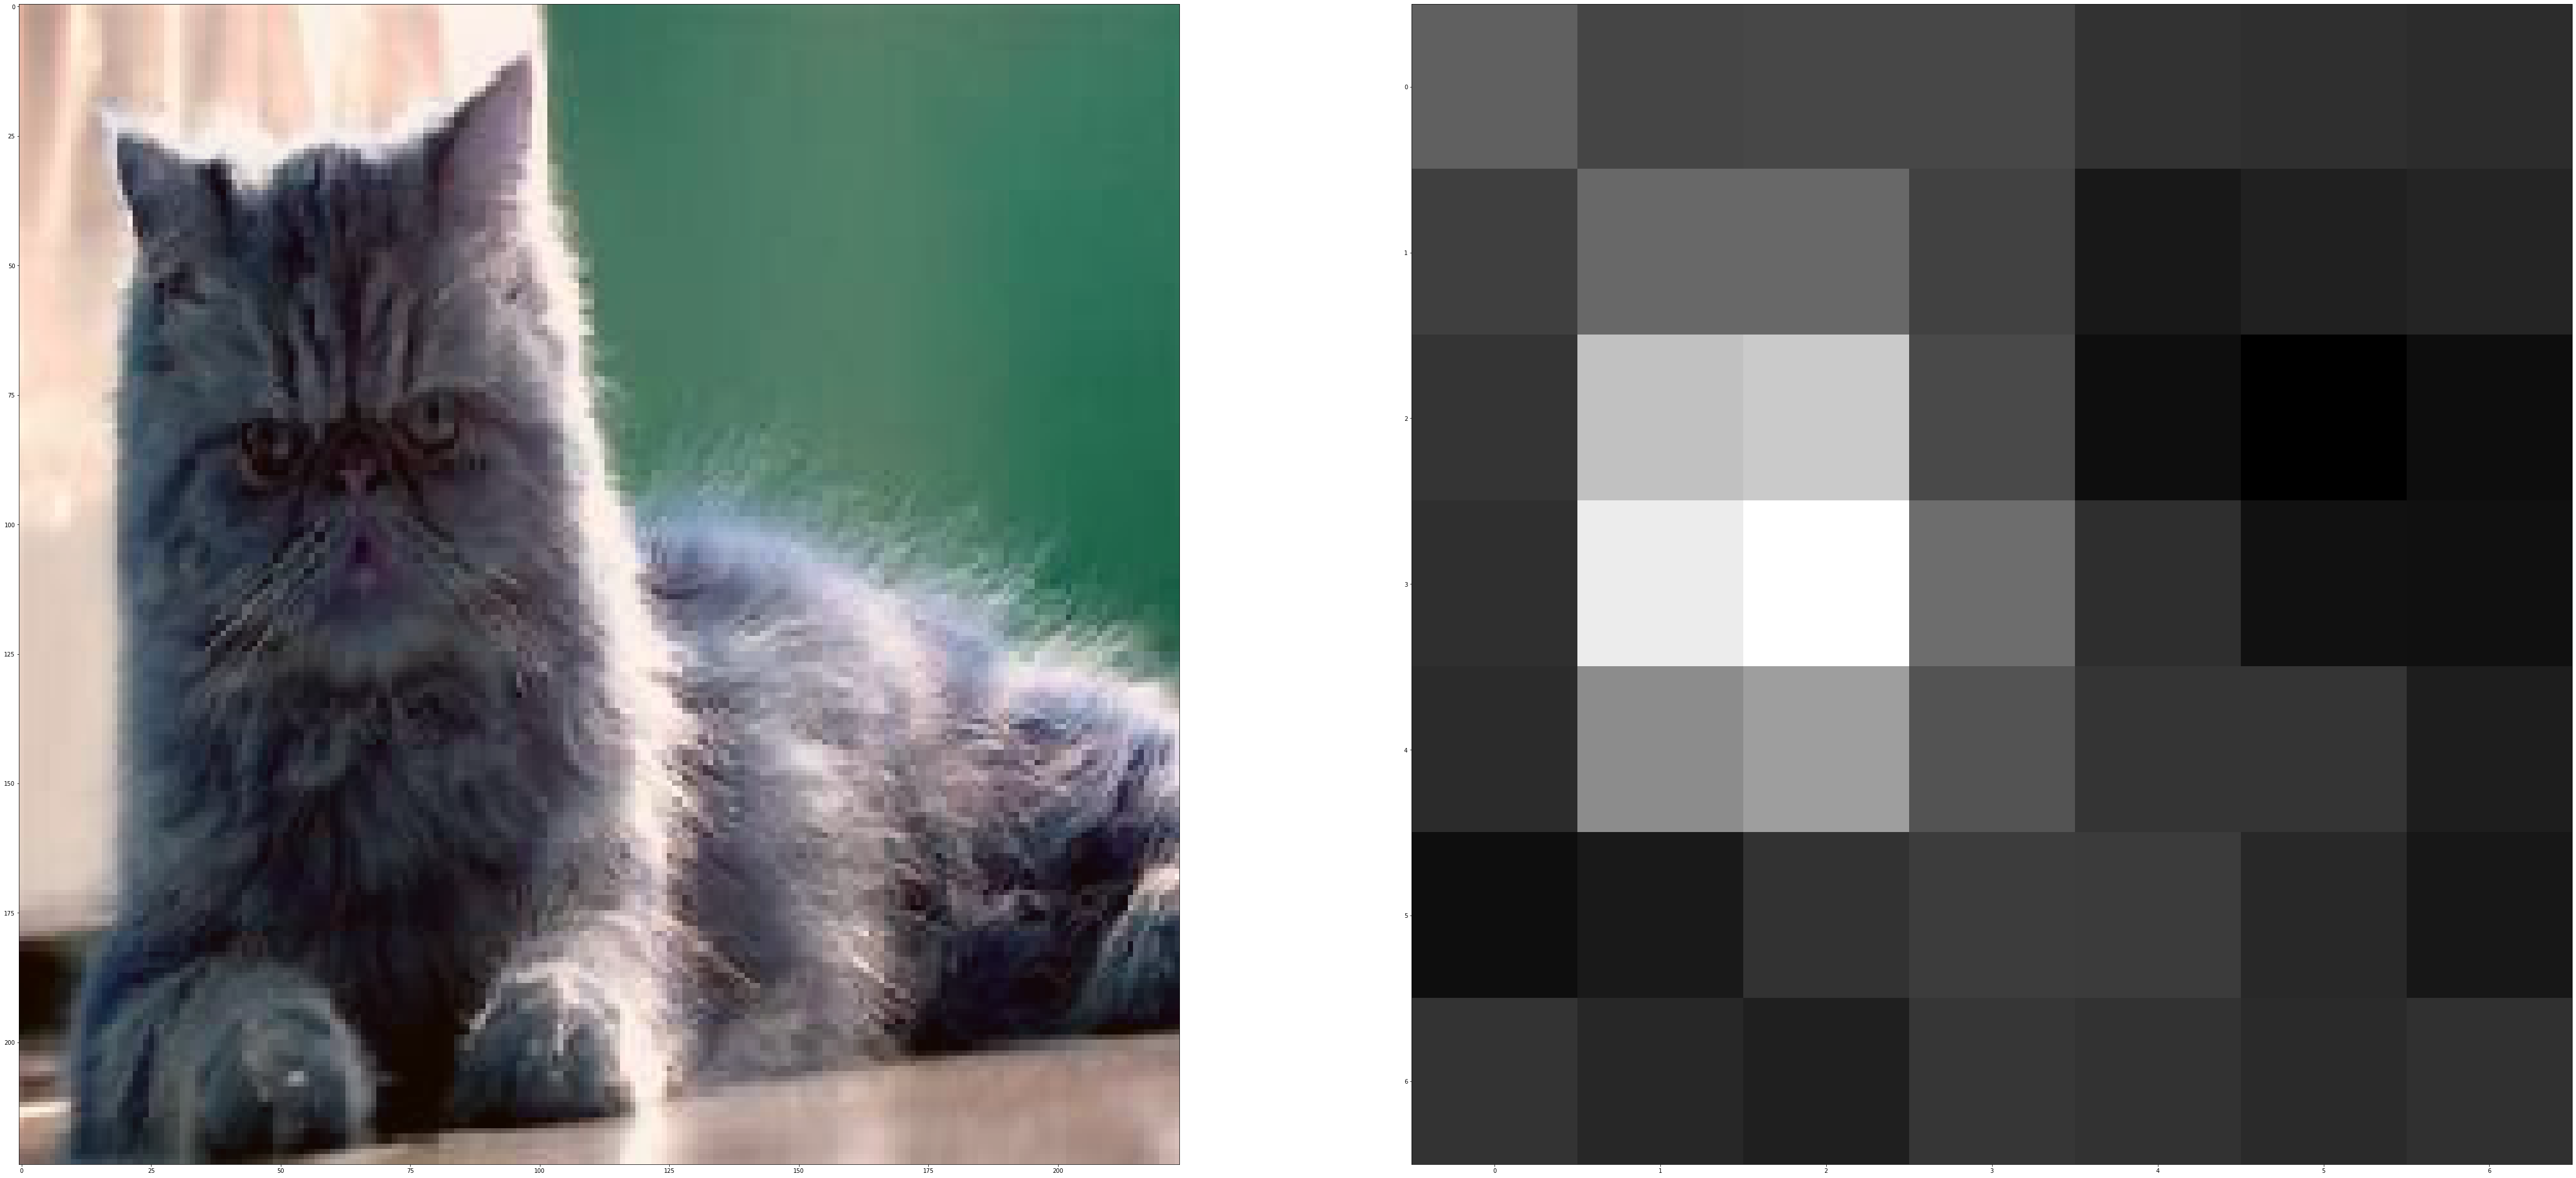

In [30]:
fig = plt.figure(figsize=(80,40))
ax = fig.add_subplot(1, 2, 1)
image = (xTest[index]-np.min(xTest[index]))/(np.max(xTest[index])-np.min(xTest[index]))
plt.imshow(image)
ax = fig.add_subplot(1, 2, 2)
leMin = np.min(cam)
leMax = np.max(cam)
camimg = (cam-leMin)/(leMax-leMin)
plt.imshow(cam, cmap = plt.cm.gray)
plt.show()

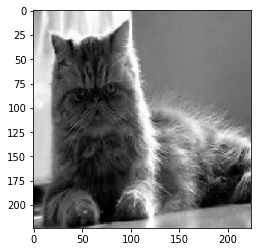

In [31]:
plt.imshow(0.5*image[:,:,1],cmap=plt.cm.gray)
plt.show()

In [32]:
print(image[:,:,1].shape)

(224, 224)


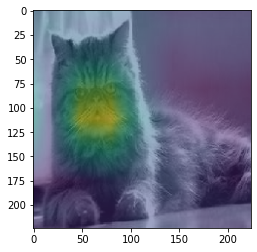

In [33]:
from skimage.transform import resize
plt.imshow(resize(camimg, (224,224)))
plt.imshow(image[:,:,1],cmap=plt.cm.gray, alpha=0.5)
plt.show()

In [68]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2

In [79]:
# code from https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353
def makeHeatmap(im, layername):
  gradModel = Model(
  inputs=[model.inputs],
  outputs=[model.get_layer(layername).output,
  model.output])
  with tf.GradientTape() as tape:
    # cast the image tensor to a float-32 data type, pass the
    # forward propagate the image through the gradient model, and grab the loss
    # associated with the specific class index
    inputs = tf.cast(im, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
  # use automatic differentiation to compute the gradients
  grads = tape.gradient(loss, convOutputs)
  # compute the guided gradients
  castConvOutputs = tf.cast(convOutputs > 0, "float32")
  castGrads = tf.cast(grads > 0, "float32")
  guidedGrads = castConvOutputs * castGrads * grads
  # the convolution and guided gradients have a batch dimension
  # (which we don't need) so let's grab the volume itself and
  # discard the batch
  convOutputs = convOutputs[0]
  guidedGrads = guidedGrads[0]
  # compute the average of the gradient values, and using them
  # as weights, compute the ponderation of the filters with
  # respect to the weights
  weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
  cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  # grab the spatial dimensions of the input image and resize
  # the output class activation map to match the input image
  # dimensions
  (w, h) = (im.shape[2], im.shape[1])
  heatmap = cv2.resize(cam.numpy(), (w, h))
  # normalize the heatmap such that all values lie in the range
  # [0, 1], scale the resulting values to the range [0, 255],
  # and then convert to an unsigned 8-bit integer
  numer = heatmap - np.min(heatmap)
  denom = (heatmap.max() - heatmap.min()) + 0.5
  heatmap = numer / denom
  plt.imshow(heatmap)
  plt.imshow(image[:,:,1],cmap=plt.cm.gray, alpha=0.5)
  plt.show()

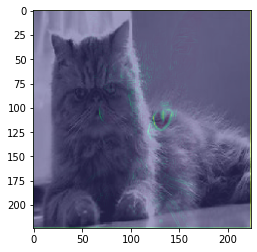

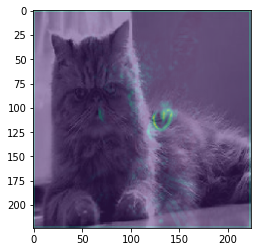

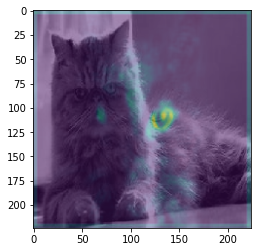

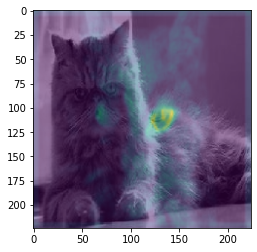

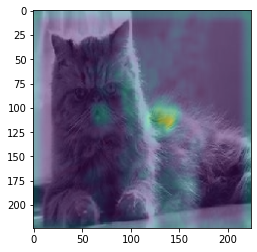

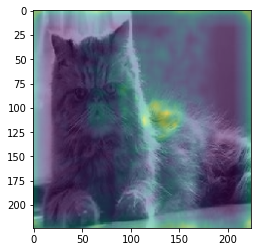

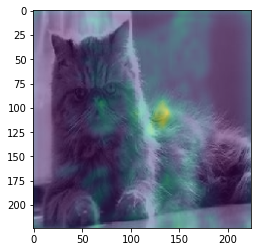

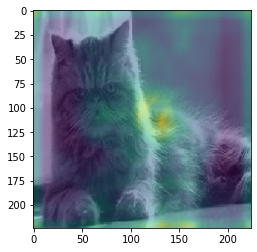

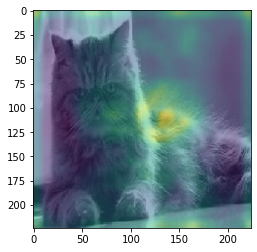

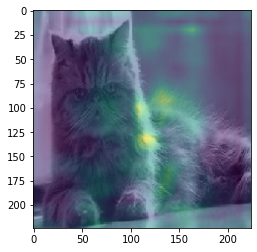

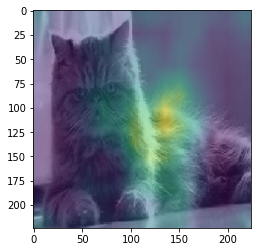

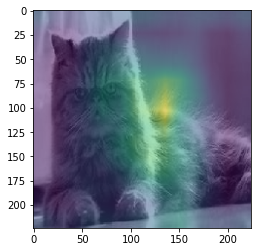

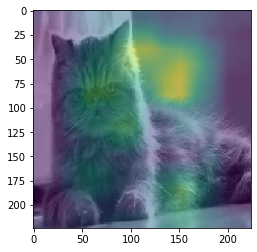

In [84]:
for layer in model.layers: 
  if "conv" in layer.name:
    makeHeatmap(im, layer.name)